# Pangeo Climatological Anomalies Workload

This is a notebook for exploring the example in https://github.com/pangeo-data/distributed-array-examples/issues/4.

Also includes code from https://github.com/cubed-dev/cubed/issues/223

In [1]:
from datetime import datetime, timedelta
import cubed
import cubed.random
from cubed.extensions.rich import RichProgressBar
import numpy as np
import xarray as xr

Initialization parameters for the workload

In [2]:
t_length = 372
time = np.arange(datetime(1979,1,1), datetime(2022,1,1), timedelta(hours=1)).astype('datetime64[ns]')
lat = np.linspace(-90.0, 90.0, 721)[::-1].astype(np.float32)
lon = np.linspace(0.0, 359.8, 1440).astype(np.float32)
spec = cubed.Spec(allowed_mem="3GB")  # TODO: can we reduce to 2GB?

Create random data stored in Zarr.

In [3]:
asn = cubed.array_api.astype(cubed.random.random((t_length, 721, 1440), chunks=(31, -1, -1), spec=spec), np.float32)
arrays = [asn]
paths = [
    f"{spec.work_dir}/asn_{t_length}.zarr",
]

In [4]:
# Comment in below to save then load Zarr from filesystem
# cubed.store(arrays, paths, compute_arrays_in_parallel=True, callbacks=[RichProgressBar()])

In [5]:
# asn = cubed.from_zarr(paths[0], spec=spec)

In [6]:
ds = xr.Dataset(
    {
        "asn": (['time', 'latitude', 'longitude'], asn),
    },
    coords={'time': time[:t_length], 'latitude': lat, 'longitude': lon},
)
ds

<xarray.Dataset> Size: 2GB
Dimensions:    (time: 372, latitude: 721, longitude: 1440)
Coordinates:
  * time       (time) datetime64[ns] 3kB 1979-01-01 ... 1979-01-16T11:00:00
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5001 ... 359.3 359.5 359.8
Data variables:
    asn        (time, latitude, longitude) float32 2GB cubed.Array<chunksize=(31, 721, 1440)>

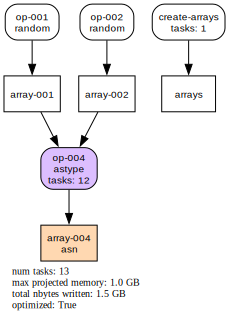

In [7]:
ds.asn.data.visualize(show_hidden=True)

In [8]:
# Note: we actually want skipna=True, but this isn't implemented in xarray yet
# see https://github.com/pydata/xarray/issues/7243
mean = ds.groupby("time.dayofyear").mean(method="map-reduce", skipna=False)
mean

TypeError: mean() got an unexpected keyword argument 'method'

In [9]:
anomaly = ds - mean.sel(dayofyear=ds.time.dt.dayofyear)
anomaly

NameError: name 'mean' is not defined

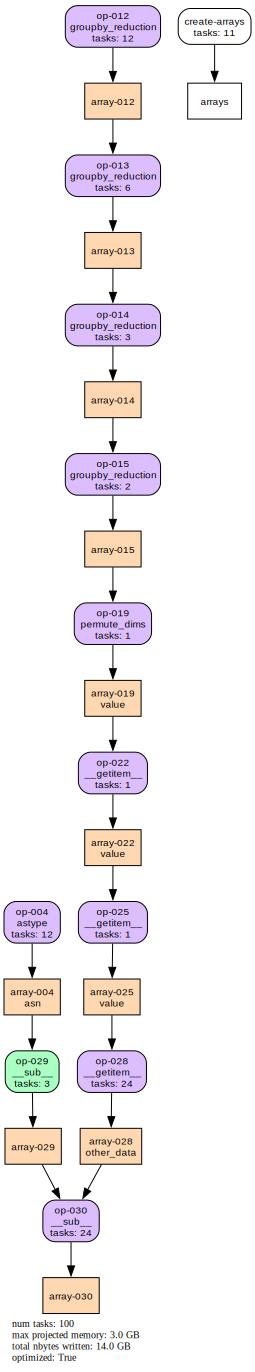

In [10]:
cubed.visualize(
    *(anomaly[var].data for var in ["asn"]),
)

In [11]:
! rm -rf anomaly.zarr

In [12]:
anomaly.to_zarr("anomaly.zarr", chunkmanager_store_kwargs=dict(callbacks=[RichProgressBar()]))

Output()